In [1]:
#15.433 - Finance Lab
#William Blair Team
#Getting the necessary inputs for the Option Pricing Model

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
#Reading the provided files
##Reading the Initial File
Col_Names_1 = ['Date', 'Issuer Name', 'Ticker', 'Country Code', 'Country', 'Debt Security Name', 'Bid Price USD', 'Yield', 'Equity Security Name', 'Equity Price USD', 'Equity Total Return', 'Fiscal Date', 'Total Assets', 'Total Liabilities', 'Total Corporate Debt', 'Total Shareholders Equity', 'Shares Outstanding', 'Dividends per Share', 'Dividends Paid', 'Dividend Yield']
Filepath_1 = 'C:\\Users\\Louccas\\Desktop\\MIT Semesters\\IAP 20-21\\15.453\\Data\\BrazilianSecurityData.csv'
Type = {'Date':'object', 'Issuer Name':'object', 'Ticker':'object', 'Country Code':'object', 'Country':'object', 'Debt Security Name':'object', 'Bid Price USD':'float64', 'Yield': 'float64', 'Equity Security Name':'object', 'Equity Price USD':'float64', 'Equity Total Return':'float64', 'Fiscal Date':'float64', 'Total Assets':'float64', 'Total Liabilities':'float64', 'Total Corporate Debt':'float64', 'Total Shareholders Equity':'float64', 'Shares Outstanding':'float64', 'Dividends per Share':'float64', 'Dividends Paid':'float64', 'Dividend Yield':'float64'}
Brazilian_Data = pd.read_csv(Filepath_1, header = 0, dtype = Type, names = Col_Names_1, na_values = ' NA')


##Reading the Maturity File
Col_Names_2 = ['Debt Name', 'Maturity']
Filepath_2 = 'C:\\Users\\Louccas\\Desktop\\MIT Semesters\\IAP 20-21\\15.453\\Data\\BrazilianMaturities.xlsx'
Brazilian_Maturities = pd.read_excel(Filepath_2, header = 0, names = Col_Names_2, na_values = ' NA')


##Reading the Treasury File
Col_Names_3 = ['Date', '3M Libor', '1Y', '3Y', '5Y', '7Y', '10Y', '15Y', '30Y']
Filepath_3 = 'C:\\Users\\Louccas\\Desktop\\MIT Semesters\\IAP 20-21\\15.453\\Data\\USTRateData.csv'
Treasury_Rate = pd.read_csv(Filepath_3, header = 0, names = Col_Names_3, na_values = ' NA')


In [4]:
company_list = Brazilian_Data.Ticker.unique()
company_list

array(['BRADES', 'BANBRA', 'BTGPBZ', 'EMBRBZ', 'GGBRBZ', 'GOLLBZ', 'ITAU',
       'MRFGBZ', 'PETBRA', 'RAILBZ'], dtype=object)

In [16]:
def info(company, bond):
    
    #First, we get the Total MV of Assets

    ##Getting the necessary inputs with the correct data type
    Total_Debt = pd.to_numeric(company['Total Corporate Debt'], errors = 'coerce').to_numpy()
    Stock_Price = pd.to_numeric(company['Equity Price USD'], errors = 'coerce').to_numpy()
    Shares_Outstanding = pd.to_numeric(company['Shares Outstanding'], errors = 'coerce').to_numpy()

    ##Getting the MV of Equity
    Equity = Stock_Price *  Shares_Outstanding

    ##Getting the MV of Assets
    MV_Assets = Total_Debt + Equity
    
    ##############################
    #Second, we get the Assets' Volatility

    ##We calculate the equity volatility
    Lambda = 0.9075


    Equity_Returns = pd.to_numeric(company['Equity Total Return'], errors = 'coerce').to_numpy()
    l = len(Equity_Returns)
    #Equity_Volatility = np.zeros(l)
    #Equity_Volatility[1] = np.sqrt(Equity_Returns[0]**2)


    ## Using EWMA, assume we are using last 250 trading days (one year)
    EWMA1 = []
    n = len(Equity_Returns)-250
    for i in range(n):
        total = 0
        for j in range(250):
            total = total + (Lambda**(250-j)) * (Equity_Returns[i+j]**2)
        EWMA1.append((total*(1-Lambda))**0.5)


    ##Since we used 250 days as the time window, we cannot calculate the volatilities for the first 250 days. 
    ##For consistency in list lengths of other variables below, I filled EWMA with 250 NaN in the beginning of the list.

    EWMA = [np.nan]*250+EWMA1
    
    ##We get the D/E ratio
    DE_Ratio = Total_Debt / Equity

    ##Finally, we calculate the Asset Volatility
    #####Asset_Volatility = (1 / (1 + DE_Ratio)) * Equity_Volatility
    Asset_Volatility = (1 / (1 + DE_Ratio)) * EWMA

    ##Annuliaze Volatility
    Annual_Volatility = Asset_Volatility*np.sqrt(250)

    
    ##############################
    #Third, we get the strike price - straightforward
    Strike_Price = Total_Debt
    
    ##############################  
    #Fourth, we get the time to maturity

    ##We get the maturity of the Banorte Bond from the Brazilian Maturities File
    #bond_pattern = bond[:-17]
    Bond_Maturity = Brazilian_Maturities[Brazilian_Maturities['Debt Name'].str.contains(bond)]
    Bond_Maturity = pd.to_datetime(Bond_Maturity['Maturity'], format = '%Y%m%d').to_numpy()

    ##We get the date of the bond from the intial file
    Date = pd.to_datetime(company['Date'], format = '%Y/%m/%d').to_numpy()

    #Finally, we take the time difference between the actual date and Maturity to get the time to expiration
    Expiration_Time = ( Bond_Maturity - Date ) / (365 * 24 * 60 * 60 * 10**9)

    
    ##############################  
    #Fifth, we get the risk-free rate for the US Yield Curve
    Treasury_Date = pd.to_datetime(Treasury_Rate['Date'], format = '%Y/%m/%d').to_numpy()
    

    #For a specific trading day of the bond, we get the closest Treasury Date and for this Treasury Date the closest maturity
    Mat = np.array([0.25, 1, 3, 5, 7, 10, 15, 30])
    Risk_Free_Rate = []
    m = len(Date)
    for i in range(m):
        #Specific_Date = Date[i]
        #We get the closest day when treasury rates are reported
        #should be a list of 2555 entries
        day_difference = [abs(Date[i] - x) for x in Treasury_Date]

        #Find the index of that closest bond issuing day 
        #Need to be fixed 
        Day_Index = day_difference.index(min(day_difference))

        #We get the closest maturity for the specific date
        # should be a list of 8 entries
        maturity_difference = [abs(Expiration_Time[i].astype(np.int64) - x) for x in Mat]

        #Find the index of that closest maturity 
        Maturity_Index = maturity_difference.index(min(maturity_difference)) + 1

        Treasury_Specific_Rate = Treasury_Rate.iloc[Day_Index, Maturity_Index]
        #We get the continuously-compounded rate
        Rate = np.log(1 + Treasury_Specific_Rate)
        Risk_Free_Rate.append(Rate) 
        
    ##############################   
    ## Dividend yield 
    Dividend_yield = pd.to_numeric(company['Dividend Yield'], errors = 'coerce').to_numpy()
    Dividend_yield = Dividend_yield / 100
    Dividend_yield[0:20]

    Dividend_yield = np.log(1 + Dividend_yield)

    
    return MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield

In [17]:
def priceBS_div(S0, K, T, r, sigma, q, Type):
    d1 = (np.log(S0/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S0/K) + (r - q - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    if Type == "C":
        return S0*np.exp(-q*T)*stats.norm.cdf(d1,0,1) - K*np.exp(-r*T)*stats.norm.cdf(d2, 0, 1)
    else: 
        return K*np.exp(-r*T)*stats.norm.cdf(-d2, 0, 1) - S0*np.exp(-q*T)*stats.norm.cdf(-d1,0,1)

C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Louccas\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  co

ValueError: operands could not be broadcast together with shapes (2,) (921,) 

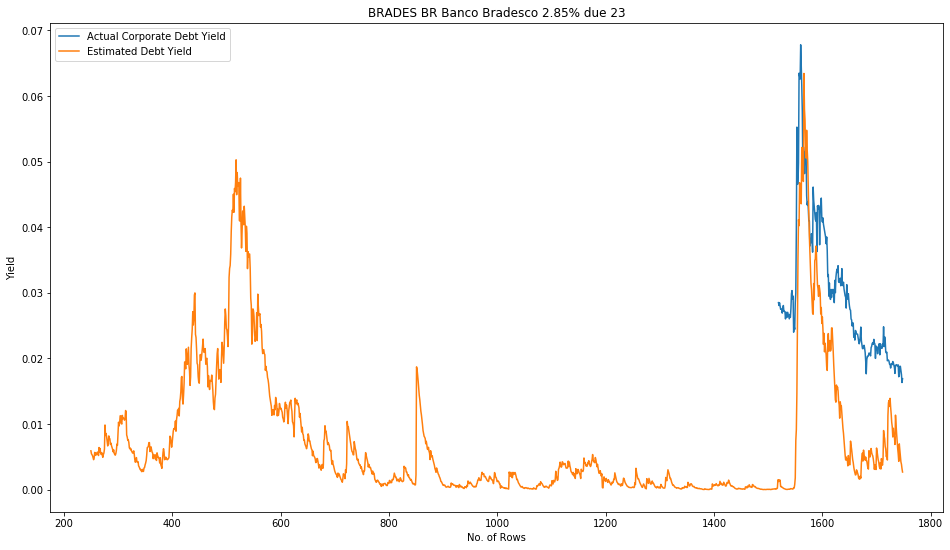

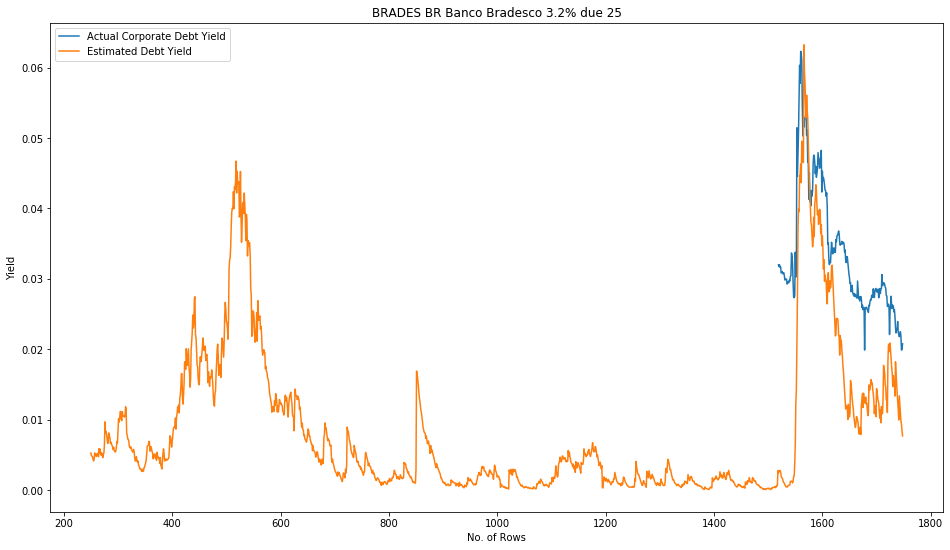

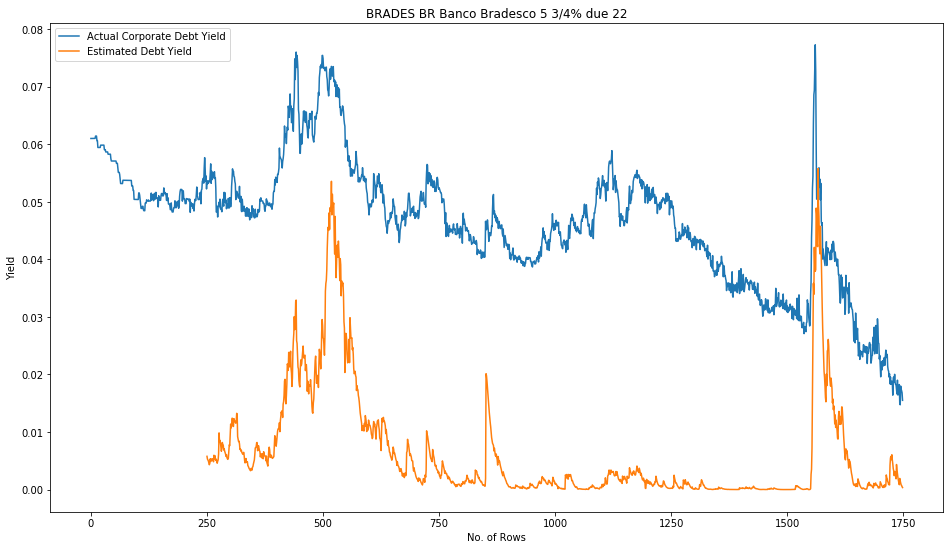

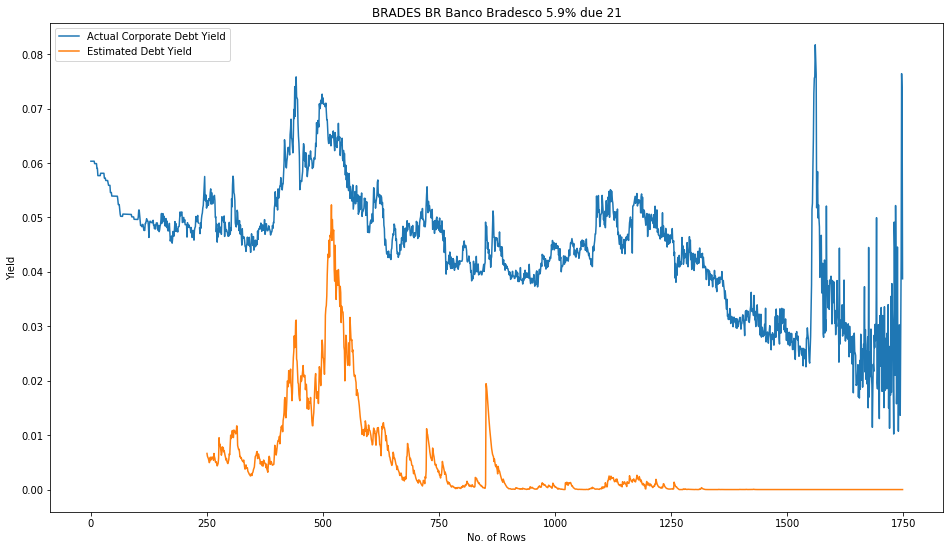

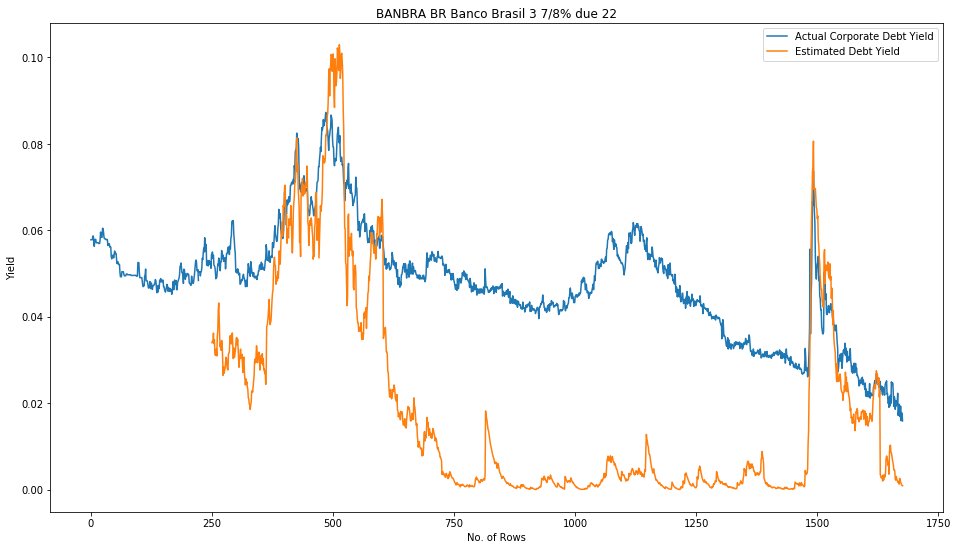

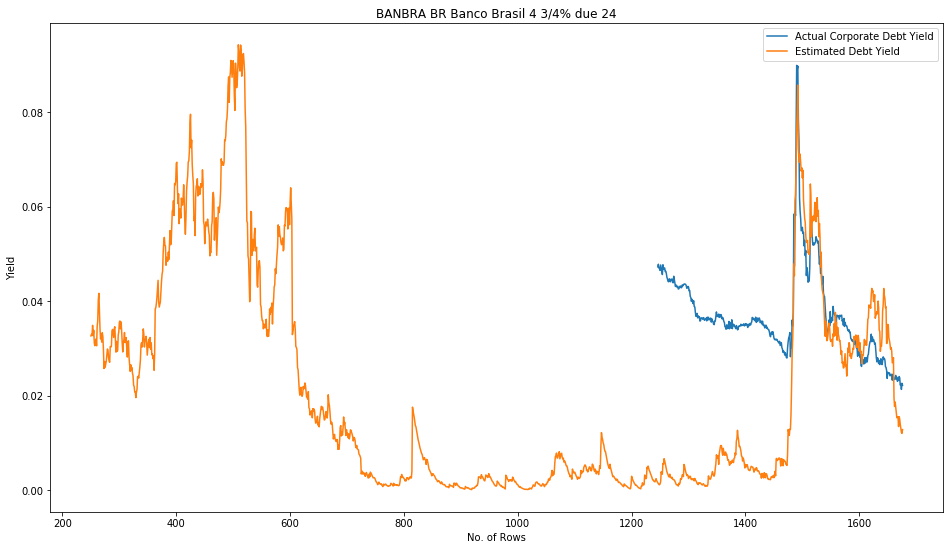

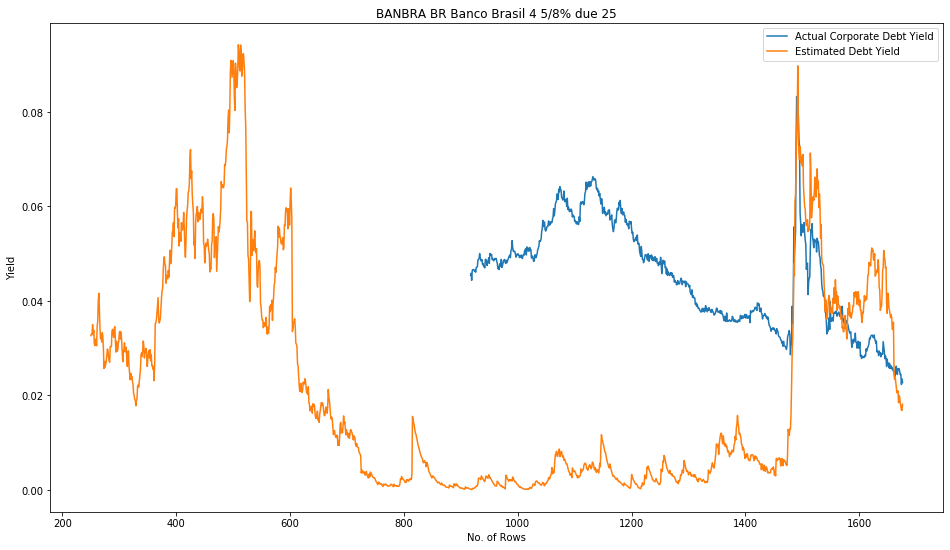

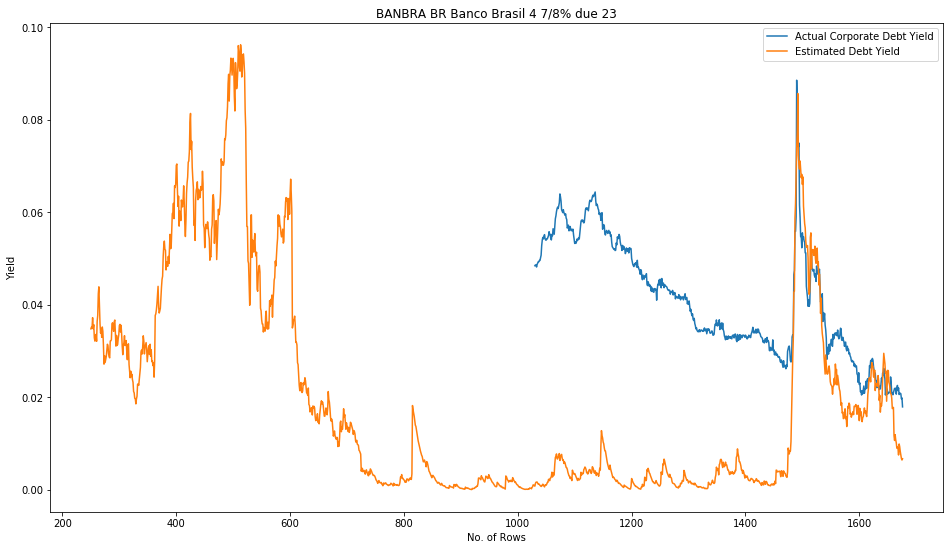

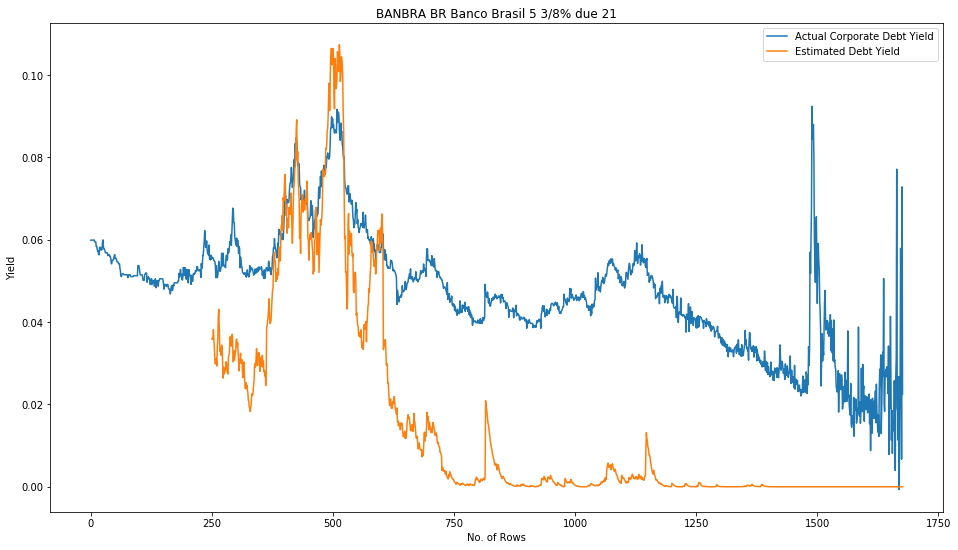

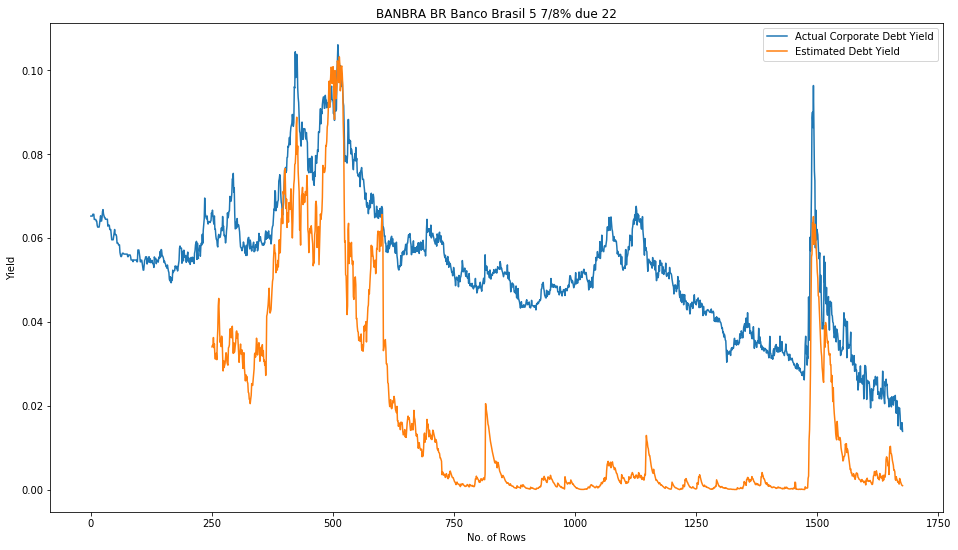

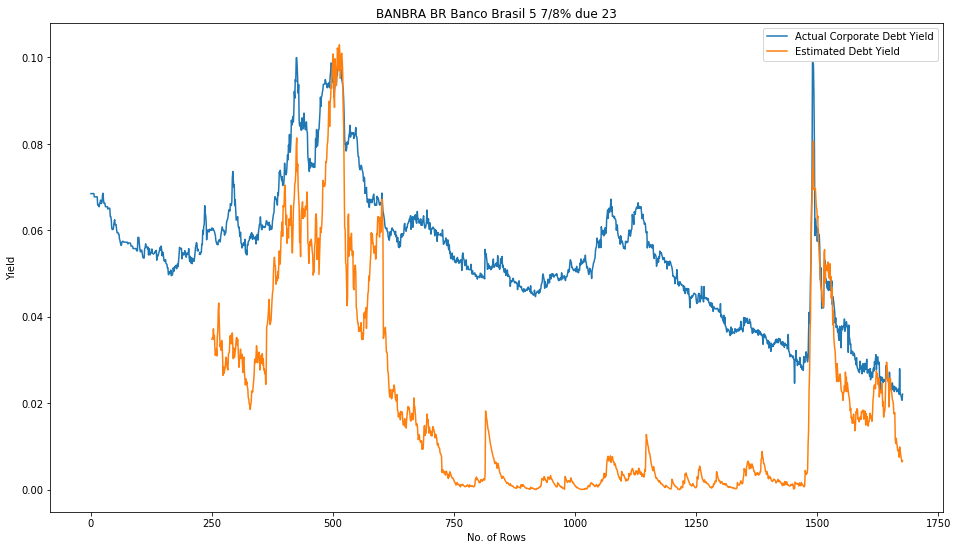

In [18]:
for c in company_list: 
    company = Brazilian_Data[Brazilian_Data['Ticker'] == c]
    # To speed up, we are thinking dropping all the dates before the bond is issued. EWMA calculation issues. Fix later.
    # company = company.dropna(subset=['Equity Total Return','Bid Price USD']).reset_index(drop=True)
    company = company.dropna(subset=['Equity Total Return'])
 
    bonds_list = company['Debt Security Name'].unique()
    ind = 0
    
    
    for b in bonds_list:
        ind += 1
        
        company_bond = company[company['Debt Security Name'] == b].reset_index(drop=True)
        
        
        # get bond-specific inputs using the previously defined function
        MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield = info(company_bond, b)
        
        
        simu_liability_price_div = []
        equity_price_div = []
        bond_yield = []
        for i in range(len(Annual_Volatility)):
            # calculate simulated value of bonds using BS model
            simu_liability_price_div.append(Strike_Price[i] - 
                                            priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                        Annual_Volatility[i], Dividend_yield[i], 'P'))
            
            # calculate bond yields
            bond_yield.append((company_bond['Total Corporate Debt'][i]/simu_liability_price_div[i])**(1/Expiration_Time[i].astype(np.int64))-1)
            
            
            # calculate equity value using BS model as call option
            # Haven't decide which variable to compare with estimated equity value
#             equity_price_div.append(priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
#                                                         Annual_Volatility[i], Dividend_yield[i], 'C'))
        
        
        # plot the estimated yield against the actual yield
        x = range(len(bond_yield))
        plt.figure(figsize=(16,9))
        plt.plot(x, company_bond['Yield'], label = "Actual Corporate Debt Yield")
        plt.plot(x, bond_yield, label = "Estimated Debt Yield")
        plt.xlabel('No. of Rows')
        plt.ylabel('Yield')
        plt.title(c + ' ' + b )
        plt.legend()
        plt.savefig(c + ' ' + str(ind) + '.png')

In [8]:
# test
Brazilian_Maturities['Debt Name'].unique()[3][:-17]

'BR Banco Brasil 5 7/8% due 23'

In [10]:
# test
a = Brazilian_Data[Brazilian_Data['Ticker'] == 'BRADES']
a['Debt Security Name'].unique()

array(['BR Banco Bradesco 2.85% due 23', 'BR Banco Bradesco 3.2% due 25',
       'BR Banco Bradesco 5 3/4% due 22', 'BR Banco Bradesco 5.9% due 21'],
      dtype=object)

In [ ]:
# test
company = Brazilian_Data[Brazilian_Data['Ticker'] == 'BANORT']
company = company.dropna(subset=['Equity Total Return'])
company_bond = company[company['Debt Security Name'] == 'MX Banorte 5 3/4% due 31'].reset_index(drop=True)

MV_Assets, Annual_Volatility, Strike_Price, Expiration_Time, Risk_Free_Rate, Dividend_yield = info(company_bond, 'MX Banorte 5 3/4% due 31')

In [ ]:
company_bond

In [ ]:
# test
simu_liability_price_div = []
equity_price_div = []
bond_yield = []
for i in range(len(Annual_Volatility)):
    # calculate simulated value of bonds using BS model
    simu_liability_price_div.append(Strike_Price[i] - 
                                    priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
                                                Annual_Volatility[i], Dividend_yield[i], 'P'))
    # calculate bond yields
    bond_yield.append((company_bond['Total Corporate Debt'][i]/simu_liability_price_div[i])**(1/Expiration_Time[i].astype(np.int64))-1) 

    # calculate equity value using BS model as call option
#     equity_price_div.append(priceBS_div(MV_Assets[i], Strike_Price[i], int(Expiration_Time[i]), Risk_Free_Rate[i], 
#                                                 Annual_Volatility[i], Dividend_yield[i], 'C'))

x = range(len(bond_yield))
plt.figure(figsize=(16,9))
plt.plot(x, company_bond['Yield'], label = "Actual Corporate Debt Yield")
plt.plot(x, bond_yield, label = "Estimated Debt Yield")
plt.xlabel('No. of Rows')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [ ]:
# test
plt.figure(figsize=(16,9))
x = range(1700)
plt.plot(x, company_bond['Total Corporate Debt'], label = "real value")
plt.plot(x, simu_liability_price_div, label = "estimated value")
plt.xlabel('No. of Rows')
plt.ylabel('Price')
plt.title('Banorte 5.2% due 30 Quoted Price Bid')
plt.legend()